In [1]:
from toolz import valmap

import h5py
import pyharm

import matplotlib.pyplot as plt
import numpy as np
from numpy import ma
from matplotlib import ticker, cm

from mpl_toolkits import mplot3d

In [2]:
i0 = 5010 # initial  frame
i1 = 5061 # 1 + last frame

fmt = 'torus.out0.{:05d}.h5'

qualities = ['RHO', 'Pg', 'bsq', 'beta', 'Theta', 'Thetae']

In [3]:
# some constants
cl = 29979245800.0 # speed of light in cgs
mp = 1.67262171e-24
kb = 1.3806505e-16
mu = 1.

In [4]:
def fname(i, src): # closure on `src` and `fmt`
    return (src+fmt).format(i)

In [5]:
src_ma_10M = '/xdisk/chanc/share/GRMHD_dt10M/Ma+0.94_w5/'
src_sa_10M = '/xdisk/chanc/share/GRMHD_dt10M/Sa+0.94_w5/'

src_ma_1000M = '/xdisk/chanc/share/GRMHD_dt1000M/Ma+0.94_w5/'
src_sa_1000M = '/xdisk/chanc/share/GRMHD_dt1000M/Sa+0.94_w5/'

dump0 = pyharm.load_dump(fname(i0, src_ma_10M))
R_low = 1.
R_high = [1, 10, 40, 160]
# first row of SANE model params

In [6]:
def get_dumps(i0, i1, src, step=1):
    dumps = {}
    for i in range(i0, i1, step):
        dumps[str(i)] = pyharm.load_dump(fname(i, src))
    return dumps

for later variance($\rho$|$P_{g}$|$P_{mag}$) calculations

In [7]:
def average(irange, dumps, keys):
    s = {k:0 for k in keys}
    for i in irange:
        # print('i:', i)
        # Because data I/O is expensive, we load the data once ...
        d = dumps[str(i)].cache
        # print('d:', d)
        # ... and then sum over multiple keys
        for k in keys:
            s[k] += d[k] # i.e.: s[key1] = file1[key1] + file2[key1] + file3[key1] + ...
            # print('s[k]:', s[k])
            # print('d[k]', d[k])
    print('finish average calculation.')
    return valmap(lambda v: v/len(irange), s) # return an average of variables from the files read in

In [8]:
# works; returns an array of arrays with numerical values
def variance(irange, dumps, quality='Te'):
    """
    quality: str, the physical quality whose variance values we want (e.g. 'Te' for electron temperature)
    dumps: dictionary, all the dump files read in
    """
    key = 'var' + quality
    ss = {key: 0}
    for i in irange:
        d = dumps[str(i)].cache
        ss[key] += (d[quality]-d['avg' + quality])**2
    for i in irange:
        dumps[str(i)].cache[key] = ss[key]
    print('finish variance & standard deviation calculation\'s loop.')
    # return valmap(lambda v: v/len(irange), ss)

$\gamma = \frac{4}{3}$, $x_{e} = \frac{1}{4}$, so ions:electrons = 3:1 (y=1, z=3; $\gamma_{i}=\gamma=\frac{4}{3}, \gamma_e = \gamma + x_{e} / (1 - x_{e})(5/3 - \gamma) = \frac{7}{3}$) <br> 
$Const = m_{p}(\gamma_{e}-1)(\gamma_{i}-1)$ <br> 
$const1 = y(\gamma_{i}-1)$ <br>
$const2 = z(\gamma_{e}-1)$ <br>
$const3 = k_{B}(\gamma-1)$

In [9]:
# constants used for the functions
y = 1.
z = 3.
gamma = 4/3
gamma_i = 4/3
gamma_e = 7/3
const = mp*(gamma_e - 1)*(gamma_i - 1)
const1 = y*(gamma_i - 1)
const2 = z*(gamma_e - 1)
const3 = kb*(gamma - 1)

$R=\frac{R_{low}}{P_{mag}^{2}+P_{g}^{2}}+\frac{R_{high}P_{g}^{2}}{P_{mag}^{2}+P_{g}^{2}}$

In [10]:
def R(dump, Rh, Rl, Pmag):
    Pg = dump['Pg']
    return Rl/(Pmag**2+Pg**2)+Rh*Pg**2/(Pmag**2+Pg**2)

The derived correlation functions: https://www.overleaf.com/project/648f4ef47315ccb8acbff565 <br>
For variance($\rho$): $F_{1}(\rho, P_{g}, P_{mag}) = -\frac{Const}{const3}\frac{P_{g}}{\rho^{2}\cdot k_{B}[const1+R\cdot const2]}$ <br>
For variance($P_{g}$): $F_{2}(P_{g}, P_{mag})= \frac{Const}{c3}[\frac{1}{c1+c2\cdot(\frac{P_{mag}^{2}R_{low}}{P_{mag}^{2}+P_{g}^{2}}+\frac{P_{g}^{2}R_{high}}{P_{mag}^{2}+P_{g}^{2}})}-\frac{c2P_{g}(\frac{2R_{high}P_{g}}{P_{mag}^{2}+P_{g}^{2}}-\frac{2R_{high}P_{g}^{3}}{(P_{mag}^{2}+P_{g}^{2})^{2}}-\frac{2R_{low}P_{g}}{(P_{mag}^{2}+P_{g}^2)^{2}})}{(c1+c2\cdot(\frac{P_{mag}^{2}R_{low}}{P_{mag}^{2}+P_{g}^{2}}+\frac{P_{g}^{2}R_{high}}{P_{mag}^{2}+P_{g}^{2}})^{2}}]$ <br>
For variance($P_{mag}$): $F_{3}(P_{g}, P_{mag}) = \frac{c2(R_{high}-R_{low})P_{g}^{2}}{[c1\cdot(P_{mag}^{2}+P_{g}^{2})+c2\cdot(P_{mag}^{2}R_{low}+P_{g}^{2}R_{high})]^{2}}$ 

In [11]:
# rho
def F1(dump, Rh, Rl):
    rho = dump['RHO']
    Pg = dump['Pg']
    B2 = dump['bsq']
    Pmag = B2/(2*mu)
    r = R(dump, Rh, Rl, Pmag)
    
    frac = Pg/(rho**2*kb*(const1+r*const2))
    val = -const/const3*frac
    dump.cache['coeff1'] = val

In [12]:
# Pg
def F2(dump, Rh, Rl):
    rho = dump['RHO']
    Pg = dump['Pg']
    B2 = dump['bsq']
    Pmag = B2/(2*mu)
    r = R(dump, Rh, Rl, Pmag)
    
    frac1 = 1/(const1*(Pmag**2+Pg**2)+const2*(Pmag**2*Rl/(Pmag**2+Pg**2)+Pg**2*Rh/(Pmag**2+Pg**2)))
    numerator2 = const2*Pg*(2*Rh*Pg/(Pmag**2+Pg**2)-2*Rh*Pg**3/(Pmag**2+Pg**2)**2-2*Rl*Pg/(Pmag**2+Pg**2)**2)
    denom2 = const1+const2*(Pmag**2*Rl/(Pmag**2+Pg**2)+Pg**2*Rh/(Pmag**2+Pg**2))
    dump.cache['coeff2'] = const/const3*(frac1-numerator2/denom2)

In [13]:
# P_mag
def F3(dump, Rh, Rl):
    rho = dump['RHO']
    Pg = dump['Pg']
    B2 = dump['bsq']
    Pmag = B2/(2*mu)
    r = R(dump, Rh, Rl, Pmag)
    
    nume = const2*(Rh-Rl)*Pg**2
    denom = (const1*(Pmag**2+Pg**2)+const2*(Pmag**2*Rl+Pg**2*Rh))**2
    dump.cache['coeff3'] = nume/denom

Read in files:

In [15]:
# MAD
dumps_ma = get_dumps(i0, i1, src_ma_10M)

In [14]:
# SANE
dumps_sa = get_dumps(i0, i1, src_sa_10M)

## Contours

In [15]:
def twoD_contour(dumps, lower_lim, upper_lim, coeff, title):
    N = 128
    x = np.linspace(lower_lim, upper_lim, N)
    y = np.linspace(lower_lim, upper_lim, N)

    X, Y = np.meshgrid(x, y)
    # the [0] is used to retreive the first (128, 128) grid in the calculated coeff1 matrix
    z1 = dumps[str(i0)].cache[coeff][0]

    fig,ax=plt.subplots(1,1)
    cp = ax.contourf(X, Y, z1)
    fig.colorbar(cp) # Add a colorbar to a plot
    ax.set_title(title)
    #ax.set_xlabel('x (cm)')
    ax.set_ylabel('y')
    plt.show()

In [16]:
def threeD_contour(dumps, lower_lim, upper_lim, coeff, title, label):
    '''
    coeff: coeff1, coeff2, or coeff3
    label: F1, F2, or F3
    '''
    N = 128
    x = np.linspace(lower_lim, upper_lim, N)
    y = np.linspace(lower_lim, upper_lim, N)

    X, Y = np.meshgrid(x, y)
    z1 = dumps[str(i0)].cache[coeff][0]

    plt.figure(figsize=(10,10))

    ax = plt.axes(projection='3d')

    ax.plot_surface(X, Y, z1, edgecolor='royalblue', lw=0.5, rstride=8, cstride=8,
                    alpha=0.3)

    # Plot projections of the contours for each dimension.  By choosing offsets
    # that match the appropriate axes limits, the projected contours will sit on
    # the 'walls' of the graph.
    ax.contour(X, Y, z1, zdir='z', cmap='coolwarm')
    ax.contour(X, Y, z1, zdir='x', cmap='coolwarm')
    ax.contour(X, Y, z1, zdir='y', cmap='coolwarm')

    ax.set(xlim=(lower_lim, upper_lim), ylim=(lower_lim, upper_lim), xlabel='X', ylabel='Y', zlabel=label)

    plt.show()

### MAD

In [16]:
for dump in dumps_ma.values():
    dump['RHO']

### $R_{high}$ = $R_{low}$ = 1

the contour tutorial: https://matplotlib.org/stable/gallery/images_contours_and_fields/contourf_log.html <br>
https://www.tutorialspoint.com/matplotlib/matplotlib_3d_contour_plot.htm <br>
https://matplotlib.org/stable/gallery/mplot3d/contour3d_3.html

$F_{1}$

In [16]:
for dump in dumps_ma.values():
    F1(dump, R_high[0], R_low)

In [20]:
print(dumps_ma[str(i0)].cache['coeff1'].shape)

(288, 128, 128)


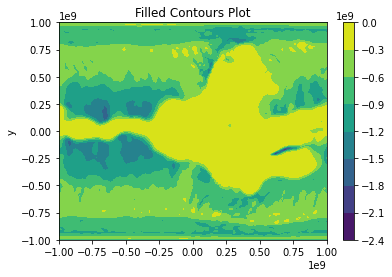

In [34]:
N = 128
x = np.linspace(-1e9, 1e9, N)
y = np.linspace(-1e9, 1e9, N)

X, Y = np.meshgrid(x, y)
# the [0] is used to retreive the first (128, 128) grid in the calculated coeff1 matrix
z1 = dumps_ma[str(i0)].cache['coeff1'][0]

fig,ax=plt.subplots(1,1)
cp = ax.contourf(X, Y, z1)
fig.colorbar(cp) # Add a colorbar to a plot
ax.set_title('Filled Contours Plot')
#ax.set_xlabel('x (cm)')
ax.set_ylabel('y')
plt.show()

Try and make a movable 3D contour plot in MatLab?

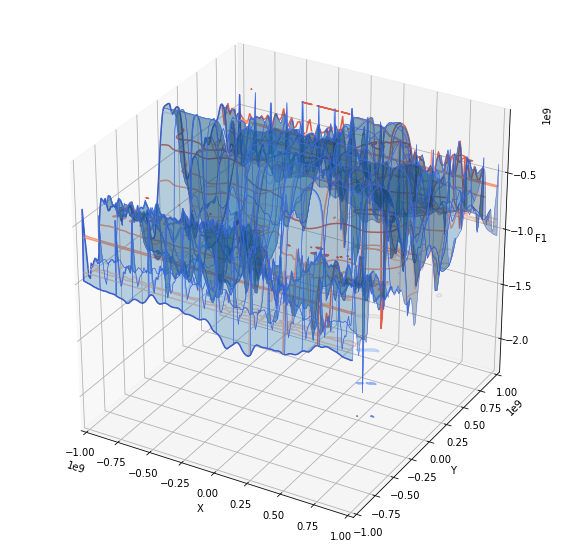

In [33]:
N = 128
x = np.linspace(-1e9, 1e9, N)
y = np.linspace(-1e9, 1e9, N)

X, Y = np.meshgrid(x, y)
z1 = dumps_ma[str(i0)].cache['coeff1'][0]

plt.figure(figsize=(10,10))

ax = plt.axes(projection='3d')

ax.plot_surface(X, Y, z1, edgecolor='royalblue', lw=0.5, rstride=8, cstride=8,
                alpha=0.3)

# Plot projections of the contours for each dimension.  By choosing offsets
# that match the appropriate axes limits, the projected contours will sit on
# the 'walls' of the graph.
ax.contour(X, Y, z1, zdir='z', cmap='coolwarm')
ax.contour(X, Y, z1, zdir='x', cmap='coolwarm')
ax.contour(X, Y, z1, zdir='y', cmap='coolwarm')

ax.set(xlim=(-1e9, 1e9), ylim=(-1e9, 1e9), xlabel='X', ylabel='Y', zlabel='F1')

plt.show()

$F_{2}$

In [18]:
for dump in dumps_ma.values():
    F2(dump, R_high[0], R_low)

In [19]:
print(dumps_ma[str(i0)].cache['coeff2'][0])

[[2.11745250e-10 2.11585002e-10 2.11800973e-10 ... 2.12718824e-10
  2.12595850e-10 2.12170054e-10]
 [2.26586448e-10 2.27518587e-10 2.27672536e-10 ... 2.27015427e-10
  2.25695148e-10 2.25696738e-10]
 [2.58961508e-10 2.59376199e-10 2.59484699e-10 ... 2.56730798e-10
  2.57167936e-10 2.57954990e-10]
 ...
 [2.55281846e-10 2.53672351e-10 2.53815383e-10 ... 2.54812947e-10
  2.55513497e-10 2.56096864e-10]
 [2.30954343e-10 2.30653857e-10 2.31007327e-10 ... 2.30190073e-10
  2.30749363e-10 2.31291749e-10]
 [2.16493775e-10 2.17183127e-10 2.17859700e-10 ... 2.16664656e-10
  2.16555424e-10 2.16157569e-10]]


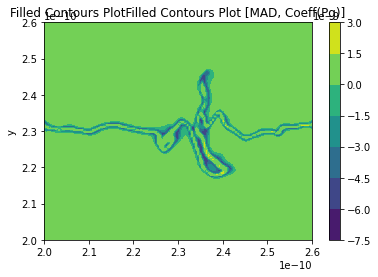

In [21]:
twoD_contour(dumps_ma, 2e-10, 2.6e-10, 'coeff2', 'Filled Contours Plot [MAD, Coeff(Pg)]')

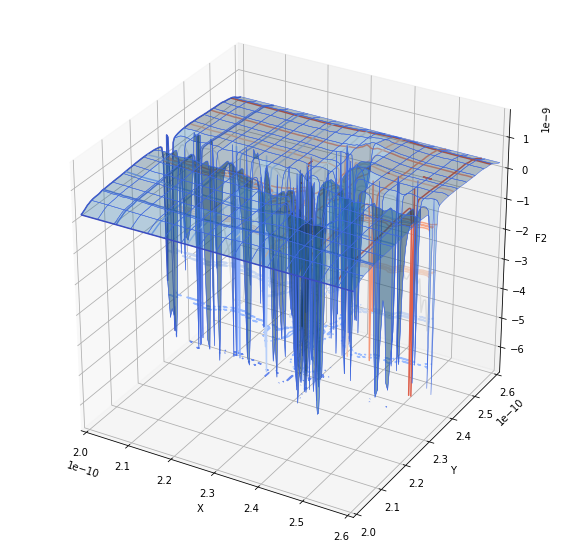

In [22]:
threeD_contour(dumps_ma, 2e-10, 2.6e-10, 'coeff2', '3D Contours Plot [MAD, Coeff(Pg)]', 'F2')

$F_{3}$

In [17]:
for dump in dumps_ma.values():
    F3(dump, R_high[0], R_low)

In [18]:
print(dumps_ma[str(i0)].cache['coeff3'][0])

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


??? why all zeros

In [ ]:
twoD_contour(dumps_ma, 2e-10, 2.6e-10, 'coeff3', 'Filled Contours Plot [MAD, Coeff(P_mag)]')

### $R_{high}$=160, $R_{low}$=1

$F_{1}$

In [18]:
for dump in dumps_ma.values():
    F1(dump, R_high[3], R_low)

In [19]:
print(dumps_ma[str(i0)].cache['coeff1'].shape)

(288, 128, 128)


In [20]:
print(dumps_ma[str(i0)].cache['coeff1'])

[[[-4.82530214e+08 -4.83418293e+08 -4.93168072e+08 ... -5.10428198e+08
   -5.03940508e+08 -4.91500734e+08]
  [-2.54728418e+08 -2.47291760e+08 -2.52017658e+08 ... -2.92232741e+08
   -2.81714783e+08 -2.69573162e+08]
  [-3.88166164e+08 -3.82858347e+08 -3.97097344e+08 ... -4.33372204e+08
   -4.18087779e+08 -4.02455846e+08]
  ...
  [-4.09966193e+08 -3.93037197e+08 -3.78369321e+08 ... -4.03639231e+08
   -4.13707487e+08 -4.13650963e+08]
  [-2.81983398e+08 -2.79371739e+08 -2.90737106e+08 ... -3.11526932e+08
   -3.12216355e+08 -3.02817325e+08]
  [-5.03622271e+08 -5.12191695e+08 -5.22587648e+08 ... -5.29155151e+08
   -5.26152970e+08 -5.10332823e+08]]

 [[-3.10454388e+08 -3.08246395e+08 -3.09708855e+08 ... -3.21405729e+08
   -3.22437177e+08 -3.17978031e+08]
  [-1.94147136e+08 -1.86103658e+08 -1.89852048e+08 ... -2.27190246e+08
   -2.17700328e+08 -2.06165104e+08]
  [-3.12484825e+08 -2.98359490e+08 -3.02838042e+08 ... -3.48480052e+08
   -3.48146698e+08 -3.30788729e+08]
  ...
  [-3.23810802e+08 -3.1

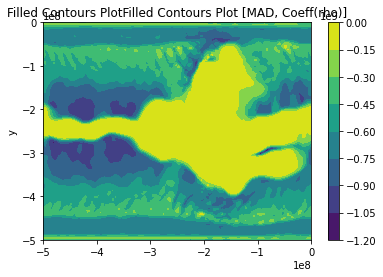

In [21]:
twoD_contour(dumps_ma, -5e8, 0., 'coeff1', 'Filled Contours Plot [MAD, Coeff(rho)]')

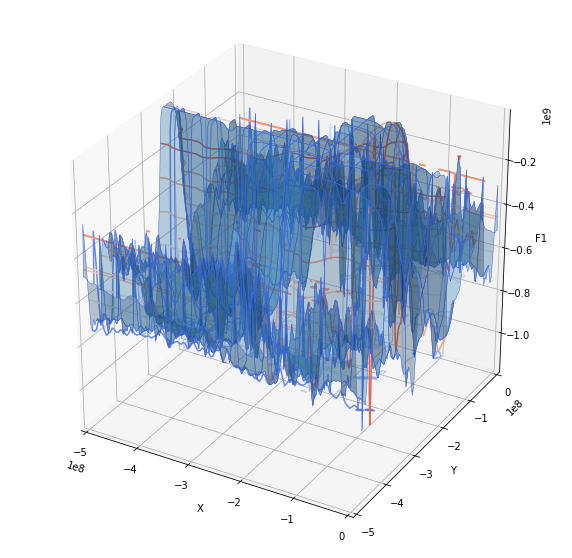

In [23]:
threeD_contour(dumps_ma, -5e8, 0., 'coeff1', '3D Contours Plot [MAD, Coeff(rho)]', 'F1')

$F_{2}$

In [18]:
for dump in dumps_ma.values():
    F2(dump, R_high[0], R_low)

In [19]:
print(dumps_ma[str(i0)].cache['coeff2'][0])

[[2.11745250e-10 2.11585002e-10 2.11800973e-10 ... 2.12718824e-10
  2.12595850e-10 2.12170054e-10]
 [2.26586448e-10 2.27518587e-10 2.27672536e-10 ... 2.27015427e-10
  2.25695148e-10 2.25696738e-10]
 [2.58961508e-10 2.59376199e-10 2.59484699e-10 ... 2.56730798e-10
  2.57167936e-10 2.57954990e-10]
 ...
 [2.55281846e-10 2.53672351e-10 2.53815383e-10 ... 2.54812947e-10
  2.55513497e-10 2.56096864e-10]
 [2.30954343e-10 2.30653857e-10 2.31007327e-10 ... 2.30190073e-10
  2.30749363e-10 2.31291749e-10]
 [2.16493775e-10 2.17183127e-10 2.17859700e-10 ... 2.16664656e-10
  2.16555424e-10 2.16157569e-10]]


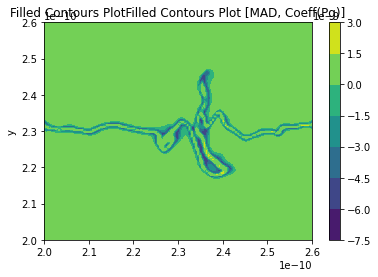

In [21]:
twoD_contour(dumps_ma, 2e-10, 2.6e-10, 'coeff2', 'Filled Contours Plot [MAD, Coeff(Pg)]')

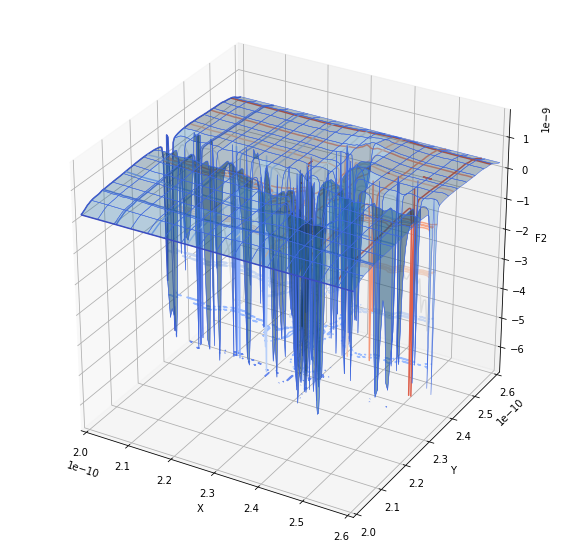

In [22]:
threeD_contour(dumps_ma, 2e-10, 2.6e-10, 'coeff2', '3D Contours Plot [MAD, Coeff(Pg)]', 'F2')

$F_{3}$

In [ ]:
for dump in dumps_ma.values():
    F3(dump, R_high[0], R_low)

In [ ]:
print(dumps_ma[str(i0)].cache['coeff2'][0])

In [ ]:
twoD_contour(dumps_ma, 2e-10, 2.6e-10, 'coeff3', 'Filled Contours Plot [MAD, Coeff(Pg)]')

### SANE

In [17]:
for dump in dumps_sa.values():
    dump['RHO']

$F_{1}$

In [16]:
for dump in dumps_sa.values():
    F1(dump, R_high[0], R_low)

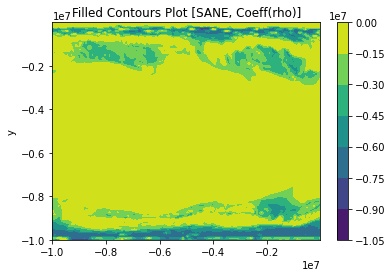

In [19]:
N = 128
x = np.linspace(-1e7, -1e3, N)
y = np.linspace(-1e7, -1e3, N)

X, Y = np.meshgrid(x, y)
z1 = dumps_sa[str(i0)].cache['coeff1'][0]

fig, ax=plt.subplots(1,1)
cp = ax.contourf(X, Y, z1)
fig.colorbar(cp) # Add a colorbar to a plot
ax.set_title('Filled Contours Plot [SANE, Coeff(rho)]')
#ax.set_xlabel('x (cm)')
ax.set_ylabel('y')
plt.show()

In [18]:
print(z1)

[[-6.70225927e+06 -6.80412941e+06 -7.76070614e+06 ... -4.14850496e+06
  -5.85225709e+06 -5.68432193e+06]
 [-1.56396951e+06 -1.72943701e+06 -1.41764832e+06 ... -3.92850467e+06
  -3.57274473e+06 -2.21756469e+06]
 [-6.42867756e+06 -6.48269031e+06 -6.54513450e+06 ... -6.35743825e+06
  -6.43545145e+06 -6.44456273e+06]
 ...
 [-1.37515234e+04 -7.60528657e+04 -3.95817728e+05 ... -2.56020285e+05
  -9.73976493e+04 -2.00244345e+05]
 [-1.58975134e+01 -7.68875997e+01 -1.80350773e+02 ... -2.52645761e+02
  -1.23372392e+02 -4.42638371e+01]
 [-1.15381804e+03 -6.98381791e+03 -5.73766517e+03 ... -2.89484830e+03
  -7.38251800e+03 -9.20474215e+03]]


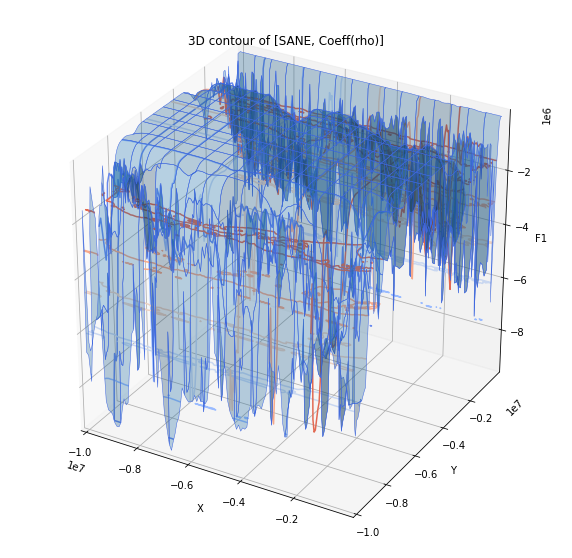

In [21]:
N = 128
x = np.linspace(-1e7, -1e3, N)
y = np.linspace(-1e7, -1e3, N)

X, Y = np.meshgrid(x, y)
z1 = dumps_sa[str(i0)].cache['coeff1'][0]

plt.figure(figsize=(10,10))

ax = plt.axes(projection='3d')

ax.plot_surface(X, Y, z1, edgecolor='royalblue', lw=0.5, rstride=8, cstride=8,
                alpha=0.3)

# Plot projections of the contours for each dimension.  By choosing offsets
# that match the appropriate axes limits, the projected contours will sit on
# the 'walls' of the graph.
ax.contour(X, Y, z1, zdir='z', cmap='coolwarm')
ax.contour(X, Y, z1, zdir='x', cmap='coolwarm')
ax.contour(X, Y, z1, zdir='y', cmap='coolwarm')

ax.set(xlim=(-1e7, -1e3), ylim=(-1e7, -1e3), xlabel='X', ylabel='Y', zlabel='F1')

plt.title('3D contour of [SANE, Coeff(rho)]')
plt.show()

$F_{2}$

In [15]:
for dump in dumps_sa.values():
    F2(dump, R_high[0], R_low)

In [19]:
print(dumps_sa[str(i0)].cache['coeff2'][0])

[[6.34638509e-09 6.50515238e-09 5.65474588e-09 ... 4.49787574e-09
  6.11532647e-09 5.32721539e-09]
 [4.20821136e-09 4.30628679e-09 4.18790744e-09 ... 4.88396138e-09
  4.77975336e-09 4.45907934e-09]
 [6.64793379e-09 6.58375322e-09 6.45099575e-09 ... 6.74601598e-09
  6.61272181e-09 6.59551621e-09]
 ...
 [1.01596294e-08 1.03046432e-06 1.58948173e-07 ... 2.88095888e-07
  1.55007809e-07 9.05885259e-07]
 [5.44986485e-04 1.02613019e-02 1.43202601e-01 ... 1.27826907e+00
  3.20357587e+00 8.45960716e+00]
 [1.51626789e-07 1.52859755e-03 5.90954807e-04 ... 8.09814455e-07
  5.17061486e-05 2.22696646e-04]]


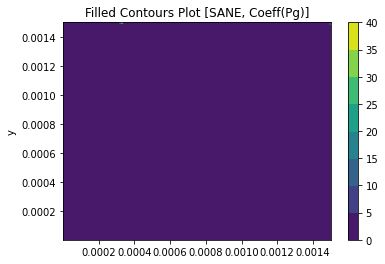

In [21]:
twoD_contour(dumps_sa, 6.5e-9, 1.5e-3, 'coeff2', 'Filled Contours Plot [SANE, Coeff(Pg)]')

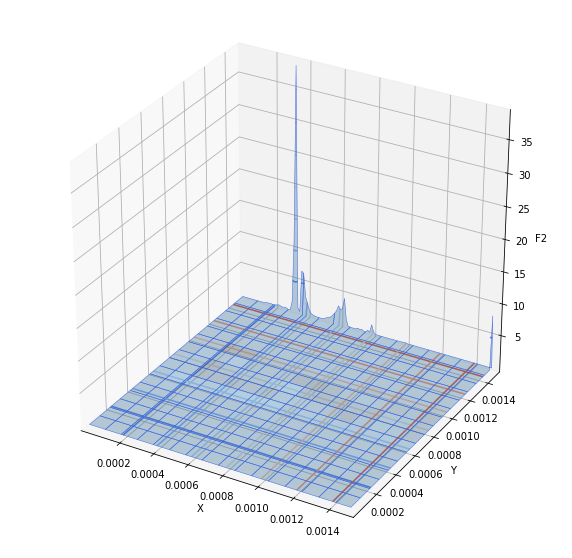

In [22]:
threeD_contour(dumps_sa, 6.5e-9, 1.5e-3, 'coeff2', 'Filled Contours Plot [SANE, Coeff(Pg)]', 'F2')

$F_{3}$

In [ ]:
for dump in dumps_sa.values():
    F3(dump, R_high[0], R_low)

### $R_{high}$=160, $R_{low}$=1

$F_{1}$

In [18]:
for dump in dumps_sa.values():
    F1(dump, R_high[3], R_low)

In [20]:
print(dumps_sa[str(i0)].cache['coeff1'][0])

[[-6.70223005e+06 -6.80409963e+06 -7.76068145e+06 ... -4.14850112e+06
  -5.85223418e+06 -5.68430839e+06]
 [-1.56396899e+06 -1.72943606e+06 -1.41764789e+06 ... -3.92849842e+06
  -3.57273944e+06 -2.21756276e+06]
 [-6.42865247e+06 -6.48266542e+06 -6.54511103e+06 ... -6.35741270e+06
  -6.43542691e+06 -6.44453834e+06]
 ...
 [-1.37515233e+04 -7.60528273e+04 -3.95816543e+05 ... -2.56019935e+05
  -9.73976209e+04 -2.00244015e+05]
 [-1.58975134e+01 -7.68875985e+01 -1.80350713e+02 ... -2.52645197e+02
  -1.23372249e+02 -4.42638178e+01]
 [-1.15381804e+03 -6.98380490e+03 -5.73765764e+03 ... -2.89484829e+03
  -7.38251721e+03 -9.20473864e+03]]


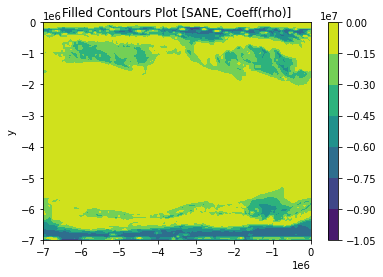

In [23]:
twoD_contour(dumps_sa, -7e6, 0., 'coeff1', 'Filled Contours Plot [SANE, Coeff(rho)]')

$F_{2}$

In [18]:
for dump in dumps_sa.values():
    F2(dump, R_high[3], R_low)

In [18]:
print(dumps_sa[str(i0)].cache['coeff2'][0])

[[6.08446100e-09 6.23279578e-09 5.47045871e-09 ... 4.44628581e-09
  5.88111466e-09 5.18590444e-09]
 [4.18941927e-09 4.27609932e-09 4.17125270e-09 ... 4.79141787e-09
  4.69632002e-09 4.41121238e-09]
 [6.38240073e-09 6.32402559e-09 6.20741013e-09 ... 6.47093913e-09
  6.35219834e-09 6.33697003e-09]
 ...
 [1.01420278e-08 9.81291196e-07 1.50541003e-07 ... 2.75158575e-07
  1.52392578e-07 8.34668961e-07]
 [5.26421197e-04 5.50877828e-03 9.16635059e-03 ... 1.11326010e-02
  2.45104511e-02 6.49066142e-02]
 [1.51514315e-07 3.32524232e-04 2.05363694e-04 ... 8.06333023e-07
  4.46265682e-05 1.37410849e-04]]


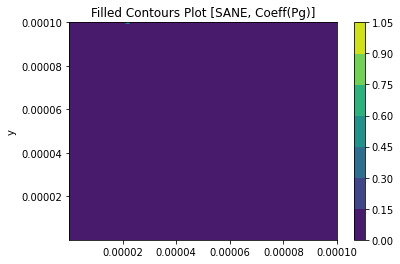

In [24]:
twoD_contour(dumps_sa, 6e-9, 3e-4, 'coeff2', 'Filled Contours Plot [SANE, Coeff(Pg)]')

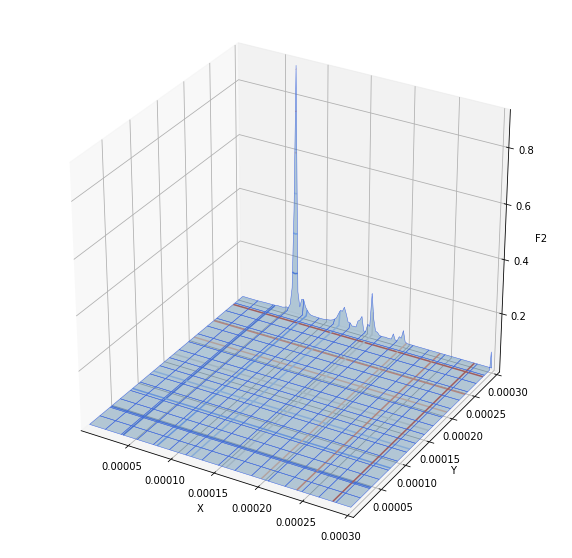

In [19]:
threeD_contour(dumps_sa, 6.5e-9, 3e-4, 'coeff2', 'Filled Contours Plot [SANE, Coeff(Pg)]', 'F2')